# 03 Geocentric Models

[Video: Statistical Rethinking 2023 - 03 - Geocentric Models](https://www.youtube.com/watch?v=tNOu-SEacNU)

## Mars from the Earth

From earth, mars seems to wander around the sky.

A statistical model could describe its movements with no understanding of the mechanism. A weak geocentric model.


## Linear Regression

__Geocentric:__ Describes associations, makes predictions but mechanistically wrong.  
__Gaussian:__ Abstracts from generative error model, replaces with normal – mechanistically silent.  

Useful when handled with care!

## Gaussian Distribution

Imagine we have a group of people who, each time a coin is flipped move right or left depending on the result. What is the distribution of the positions of those people after many steps?

10: mean 0.0, var 66.4
100: mean -0.6, var 106.5
1,000: mean 0.3, var 102.7
10,000: mean 0.1, var 99.6
100,000: mean 0.0, var 100.4


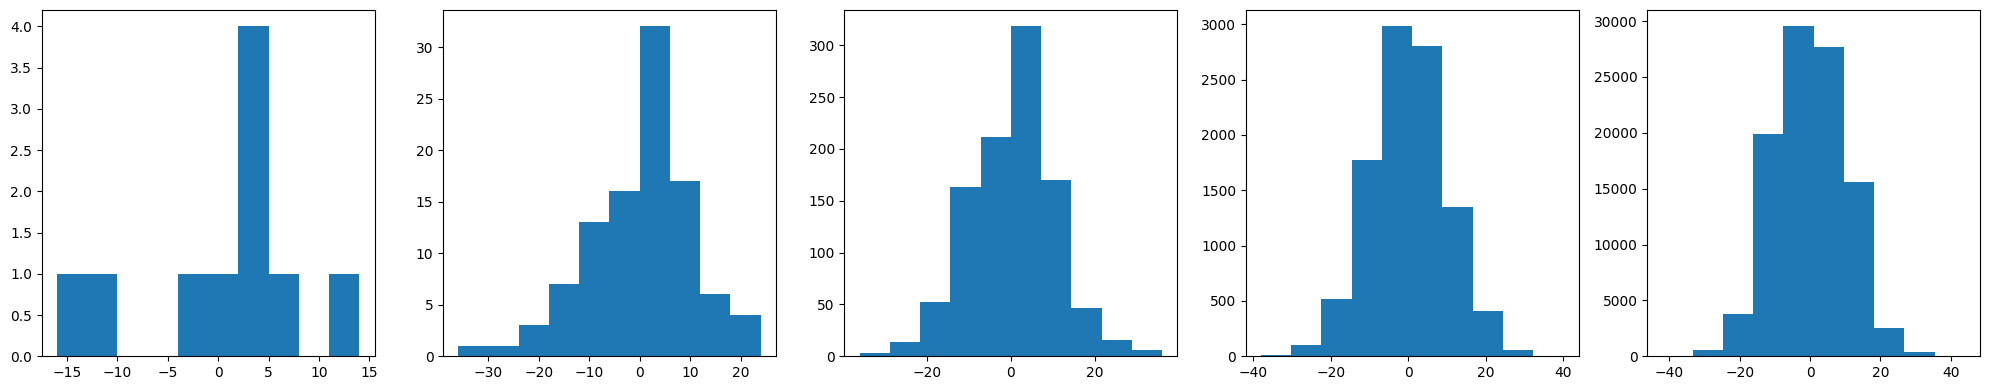

In [211]:
def simulate_movements(
    people: int = 100, steps: int = 100, probability: float = 0.5
) -> np.array:
    return np.random.choice(
        [-1, 1], p=[probability, 1 - probability], size=(people, steps)
    ).sum(axis=1)


import matplotlib.pyplot as plt

results = {
    people: simulate_movements(people) for people in [10, 100, 1_000, 10_000, 100_000]
}

fig, axs = plt.subplots(1, len(results), figsize=(len(results) * 4, 4))


for index, people in enumerate(results):
    axs[index].hist(results[people])

    print(
        f"{people:,}: mean {results[people].mean():.1f}, var {results[people].var():.1f}"
    )

plt.tight_layout()

Looks pretty gaussian! The variance is equal to the number of steps.

### Why use normal distributions in our models?

1. Generate - the summed fluctuations tend towards normal distribtion
2. Inferential - for estimating mean and variance, the normal distribution is the least informative (maximum entropy)

Note: a variable doesn't have to be normally distributed for a normal error model to be useful, it's a machine for estimating mean/variance.

## Making Geocentric Models

Goals:
- Language for representing models
- Calculate posterior dists with multiple unknowns
- Constructing and unsterstanding linear models


### Reminder of the "Owl Drawing Workflow"

1. State a clear question
2. Sketch your causal assumptions
3. Use the sketch to define a generative model
4. Use generative model to build an estimator

Linear model:
1. Question/goal/estimand
2. Scientific model
3. Statistical model
4. Validate model
5. Anlayze data


For this weight/height model:
1. Describe association between weight and height

2. Scientific model: $W = f(H)$

```mermaid
graph TD;
    H --> W;
```

Generative model...  
__Dynamic:__ Incremental growth derive from a growth pattern. Simulate people and grow them incrementally.  
__Static:__ Changes in height result in change in weight but no mechanism. Gaussian variation is a result of growth history/accumulated fluctuations.

```mermaid
graph TD;
    H --> W;
    U --> W;
```

$W = f(H, U)$

*"Weight is a function of height and some unobserved stuff"*

Equation:
$W = \beta H+U$

Text(0, 0.5, 'Weight')

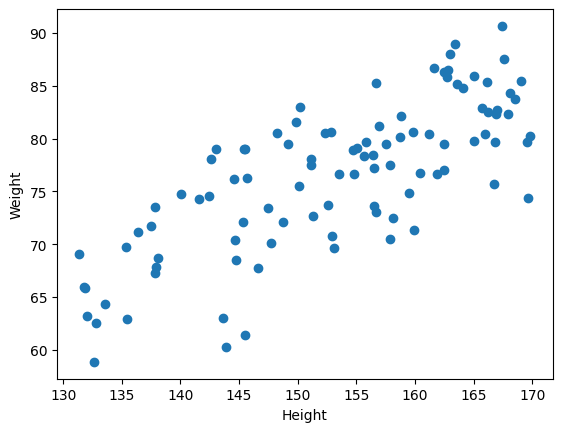

In [213]:
def sim_weight(height: np.array, beta: float, sd: float):
    U = np.random.normal(0, sd, size=len(height))
    W = beta * height + U
    return W


heights = np.random.uniform(130, 170, size=100)
weights = sim_weight(heights, beta=0.5, sd=5)

plt.scatter(heights, weights)
plt.xlabel("Height")
plt.ylabel("Weight")

## Notation: Describing Models

Concentional notation:
- List variables
- Define each as deterministic or distibutional function of the others

$W_{i} = \beta H_{i} + U_{i}$  
$U_{i} \sim \mathcal{N}(0, \sigma)$  
$H_{i} \sim Uniform(130, 170)$  

### Estimator

We want to estimate how the average weight changes with height.

Average weight conditional on height...  
$E(W_{i}|H_{i}) = \alpha + \beta H_{i}$

### Posterior


Posterior probability of the specific regression line:   
$Pr(\alpha, \beta, \sigma|H_{i}, W_{i})$

Ways of producing $W_{i}$:  
$Pr(W_{i}|H_{i}, \alpha, \beta, \sigma)$

Prior:  
$Pr(\alpha, \beta, \sigma)$

Normalize: $Z$

So:

$$Pr(\alpha, \beta, \sigma|H_{i}, W_{i}) = \frac{Pr(W_{i}|H_{i}, \alpha, \beta, \sigma)Pr(\alpha, \beta, \sigma)}{Z}$$

And: 
$$W_{i} \sim Normal(\mu_{i}, \sigma)$$
$$\mu_{i} = \alpha + \beta H_{i}$$

In [214]:
import pymc as pm

with pm.Model() as model:

    H = pm.Uniform("H", 130, 170)

    sigma = pm.Uniform("sigma", 0, 10)

    beta = pm.Uniform("beta", 0, 1)

    alpha = pm.Normal("alpha", 0, 10)

    mu = alpha + beta * H

    W = pm.Normal("W", mu, sigma)

    ppc = pm.sample_prior_predictive(return_inferencedata=True)

Sampling: [H, W, alpha, beta, sigma]


In [216]:
w = ppc.prior["alpha"] + ppc.prior["beta"] * ppc.prior["H"]

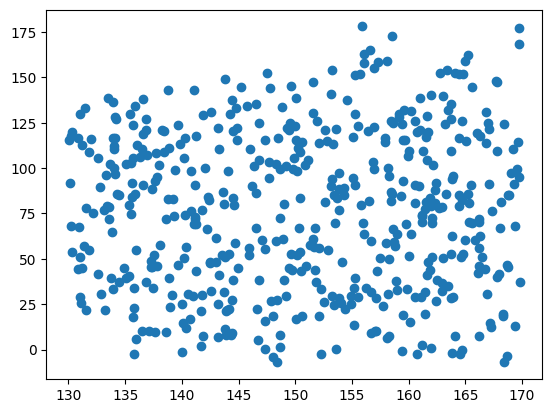

In [217]:
plt.scatter(ppc.prior["H"].values, w.values)

In [244]:
weights = sim_weight(height=heights, beta=0.5, sd=10)

In [251]:
with pm.Model() as model:

    H = pm.Data("H", heights)

    sigma = pm.Uniform("sigma", 0, 20)

    beta = pm.Uniform("beta", 0, 1)

    alpha = pm.Normal("alpha", 0, 20)

    mu = alpha + beta * H

    W = pm.Normal("W", mu, sigma, observed=weights)

    trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]


/Users/henrysimmons/Library/Caches/pypoetry/virtualenvs/statistical-rethinking-pymc-tvRae8FL-py3.11/lib/python3.11/
site-packages/rich/live.py:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


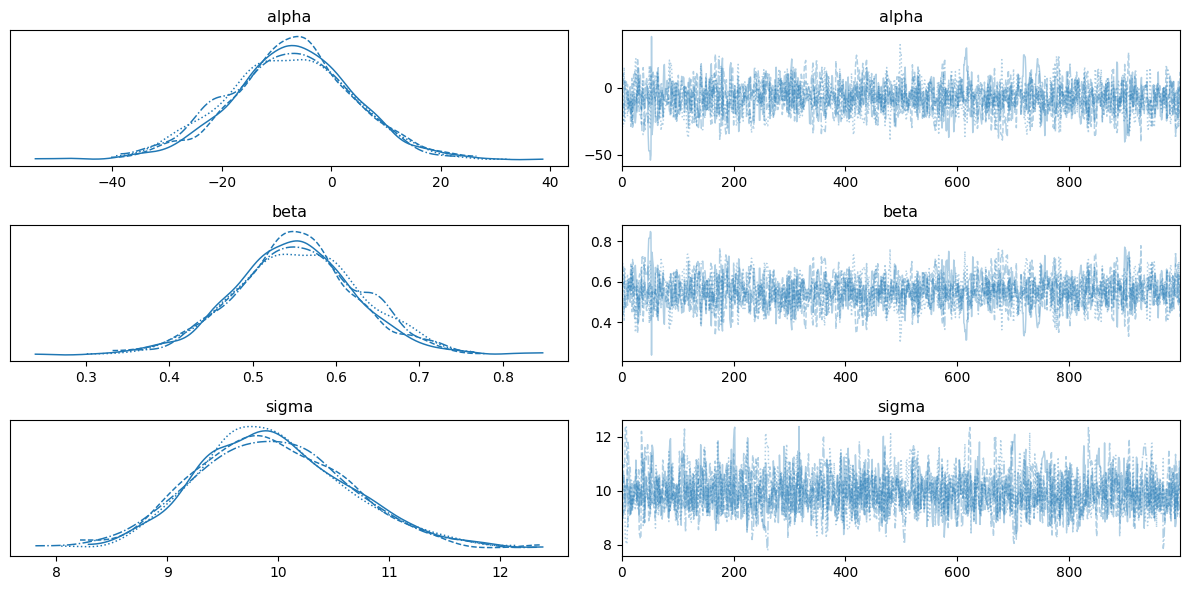

In [252]:
az.plot_trace(trace)
plt.tight_layout()

array([<Axes: title={'center': 'alpha'}>,
       <Axes: title={'center': 'beta'}>,
       <Axes: title={'center': 'sigma'}>], dtype=object)

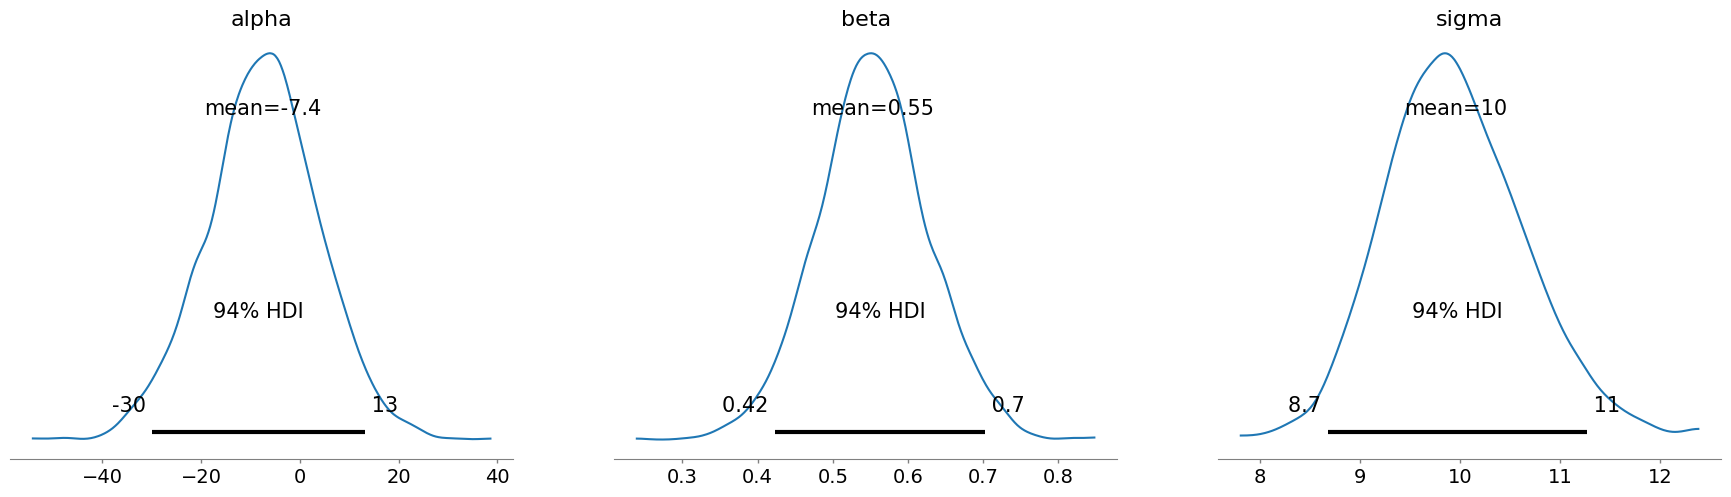

In [254]:
az.plot_posterior(trace)